# Spark Assignment: Gas Consumption in France

## Table of contents
[I. Set-up and data download](#partI)<br>
[II. Read and merge all gas files](#partII)<br>
[III. Split date in year, month, week of the year, prepare latitude & longitude for mapping](#partIII)<br>
[IV. Make data available as a table in order to be able to use Spark SQL](#partIV)<br>
[V. Through basic statistics, consider which gas types have some interest for the rest of the project](#partV)<br>
[VI. Price and Week index calculation](#partVI)<br>
[VII. Data visualisation](#partVII)<br>
[VIII. Forecast next week price](#partVIII)<br>

In [ ]:
## Custom function to enable scrolling in output sequences
def hscroll(activate=True): # from https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally
  """activate/deactivate horizontal scrolling for wide output cells"""
  from IPython.display import display, HTML

  style = ('pre-wrap','pre')[activate] # select white-space style
  display(HTML("<style>pre {white-space: %s !important}</style>" % style))
hscroll(True)

# I. Set-up and data download <a id='partI'></a>

In [ ]:
# Install Java and Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

# Initialize Spark
import findspark
findspark.init()

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=a05098d2c2c4e26ade957a5516426c89936bb612cb9c8a15643e6506643d2cbd
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()


# Check Spark Version
print(spark.sparkContext.version)

3.1.1


In [ ]:
import pyspark
print(pyspark.__file__)

/content/spark-3.1.1-bin-hadoop2.7/python/pyspark/__init__.py


In [ ]:
import py4j
print(py4j.__version__)

0.10.9


In [ ]:
!pip install PyYAML

We use a yaml file as a parameter file to provide global values to the script
(miminum: location of files (directory), first year to process, last year to
process)

In [ ]:
yaml_content = """
file_directory: "/content/"
first_year: 2019
last_year: 2021
"""

with open('config.yaml', 'w') as file:
    file.write(yaml_content)

In [ ]:
import yaml

def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Load configuration
config = load_config('config.yaml')

# Accessing parameters
file_directory = config['file_directory']
first_year = config['first_year']
last_year = config['last_year']

In [ ]:
import os
import requests
import gzip
import shutil

def download_github_files(repo_url, file_names, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for file_name in file_names:
        # Construct the full URL for the raw file content
        file_url = f'{repo_url}/{file_name}'
        # Get the file content from the URL
        response = requests.get(file_url)
        if response.status_code == 200:
            # Write the compressed file to the specified directory
            with open(os.path.join(directory, file_name), 'wb') as file:
                file.write(response.content)
            print(f"Downloaded {file_name} to {directory}")

            # Unzip the downloaded file
            unzip_file(os.path.join(directory, file_name))
        else:
            print(f"Failed to download {file_name}. Status code: {response.status_code}")

def unzip_file(file_path):
    # Remove the .gz extension to get the target file name
    target_file = os.path.splitext(file_path)[0]

    with gzip.open(file_path, 'rb') as gz_file:
        with open(target_file, 'wb') as dest_file:
            shutil.copyfileobj(gz_file, dest_file)

    print(f"Unzipped {file_path} to {target_file}")
    # Remove the compressed .gz file after unzipping
    os.remove(file_path)

# Example usage:
repo_url = 'https://github.com/rvm-courses/GasPrices/raw/master'
file_names = [
    'Prix2019.csv.gz',
    'Prix2020.csv.gz',
    'Prix2021.csv.gz',
    'Prix2022S1.csv.gz',
    'Prix2022S2.csv.gz',
    'Prix2023.csv.gz',
    'Services2022.csv.gz',
    'Stations2022.csv.gz'
]
directory = '/content'

# Call the function with the repository URL, list of files, and the target directory
download_github_files(repo_url, file_names, directory)

Downloaded Prix2019.csv.gz to /content
Unzipped /content/Prix2019.csv.gz to /content/Prix2019.csv
Downloaded Prix2020.csv.gz to /content
Unzipped /content/Prix2020.csv.gz to /content/Prix2020.csv
Downloaded Prix2021.csv.gz to /content
Unzipped /content/Prix2021.csv.gz to /content/Prix2021.csv
Downloaded Prix2022S1.csv.gz to /content
Unzipped /content/Prix2022S1.csv.gz to /content/Prix2022S1.csv
Downloaded Prix2022S2.csv.gz to /content
Unzipped /content/Prix2022S2.csv.gz to /content/Prix2022S2.csv
Downloaded Prix2023.csv.gz to /content
Unzipped /content/Prix2023.csv.gz to /content/Prix2023.csv
Downloaded Services2022.csv.gz to /content
Unzipped /content/Services2022.csv.gz to /content/Services2022.csv
Downloaded Stations2022.csv.gz to /content
Unzipped /content/Stations2022.csv.gz to /content/Stations2022.csv


In [ ]:
# List files in the directory
files = os.listdir('/content')
print(files)

['.config', 'Prix2022S2.csv', 'Prix2020.csv', 'Stations2022.csv', 'Prix2023.csv', 'Prix2019.csv', 'spark-3.1.1-bin-hadoop2.7', 'Prix2022S1.csv', 'Services2022.csv', 'config.yaml', 'spark-3.1.1-bin-hadoop2.7.tgz', 'Prix2021.csv', 'sample_data']


# II. Read and merge all gas files <a id='partII'></a>

In [ ]:
# Import necessary libraries
from pyspark.sql.functions import split, year, month, weekofyear, col, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType,DoubleType


# Define Schemas for Each File Type
price_schema = StructType([
    StructField("id_pdv", IntegerType(), True),
    StructField("cp", IntegerType(), True),
    StructField("pop", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("date", StringType(), True),
    StructField("id_carburant", IntegerType(), True),
    StructField("nom_carburant", StringType(), True),
    StructField("prix", IntegerType(), True)
])

stations_schema = StructType([
    StructField("id_pdv", IntegerType(), True),
    StructField("cp", IntegerType(), True),
    StructField("pop", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("adresse", StringType(), True),
    StructField("ville", StringType(), True)
])

services_schema = StructType([
    StructField("id_pdv", IntegerType(), True),
    StructField("cp_pdv", IntegerType(), True),
    StructField("pop", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("services", StringType(), True)
])

# Read the Files
price_df = spark.read.csv("/content/Prix*.csv", schema=price_schema, sep=";")
stations_df = spark.read.csv("/content/Stations2022.csv", schema=stations_schema
                             , sep="|")
services_df = spark.read.csv("/content/Services2022.csv", schema=services_schema
                             , sep="|")

* Use a yaml file as a parameter file to provide global values to the script
(miminum: location of files (directory), first year to process, last year to
process)

In [ ]:
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import TimestampType

#Convert String to Timestamp
price_df = price_df.withColumn('date', to_timestamp(col('date'), 'yyyy-MM-dd\'T\'HH:mm:ss'))

#Filter Data Based on Year
price_df = price_df.filter((year("date") >= config['first_year']) & (year("date") <= config['last_year']))

In [ ]:
# Inspect Data
price_df.show()
stations_df.show()
services_df.show()

+-------+----+---+---------+---------+-------------------+------------+-------------+----+
| id_pdv|  cp|pop| latitude|longitude|               date|id_carburant|nom_carburant|prix|
+-------+----+---+---------+---------+-------------------+------------+-------------+----+
|1000001|1000|  R|4620114.0| 519791.0|2020-01-03 10:36:03|           1|       Gazole|1442|
|1000001|1000|  R|4620114.0| 519791.0|2020-01-06 10:36:17|           1|       Gazole|1443|
|1000001|1000|  R|4620114.0| 519791.0|2020-01-07 10:48:14|           1|       Gazole|1458|
|1000001|1000|  R|4620114.0| 519791.0|2020-01-28 15:18:55|           1|       Gazole|1456|
|1000001|1000|  R|4620114.0| 519791.0|2020-01-30 10:13:59|           1|       Gazole|1431|
|1000001|1000|  R|4620114.0| 519791.0|2020-01-31 16:58:52|           1|       Gazole|1429|
|1000001|1000|  R|4620114.0| 519791.0|2020-02-01 13:02:49|           1|       Gazole|1428|
|1000001|1000|  R|4620114.0| 519791.0|2020-02-03 12:21:46|           1|       Gazole|1430|

Let's work on the Price files from **2019** to **2021** as shown here.

In [ ]:
# Extract year from the date column
df_with_year = price_df.withColumn("year", year("date"))

# Find distinct years
distinct_years = df_with_year.select("year").distinct()

# Show the distinct years
distinct_years.show()

+----+
|year|
+----+
|2019|
|2020|
|2021|
+----+



In [ ]:
price_df.select("date").show(5, truncate=False)

+-------------------+
|date               |
+-------------------+
|2020-01-03 10:36:03|
|2020-01-06 10:36:17|
|2020-01-07 10:48:14|
|2020-01-28 15:18:55|
|2020-01-30 10:13:59|
+-------------------+
only showing top 5 rows



# III. Split date in year, month, week of the year, prepare latitude & longitude for mapping <a id='partIII'></a>

In [ ]:
from pyspark.sql.functions import year, month, weekofyear, to_timestamp
from pyspark.sql.functions import year, month, weekofyear, to_date, col

# Convert the date string to a date type
price_df = price_df.withColumn("date", to_date(col("date"), 'yyyy-MM-dd\'T\'HH:mm:ss'))

# Extract year, month, and week of the year from the date column
price_df = price_df.withColumn("year", year(col("date"))) \
                   .withColumn("month", month(col("date"))) \
                   .withColumn("week_of_year", weekofyear(col("date")))

In [ ]:
# Show the updated DataFrame with only the new columns
price_df.select("date", "year", "month", "week_of_year").show(truncate=False)

+----------+----+-----+------------+
|date      |year|month|week_of_year|
+----------+----+-----+------------+
|2020-01-03|2020|1    |1           |
|2020-01-06|2020|1    |2           |
|2020-01-07|2020|1    |2           |
|2020-01-28|2020|1    |5           |
|2020-01-30|2020|1    |5           |
|2020-01-31|2020|1    |5           |
|2020-02-01|2020|2    |5           |
|2020-02-03|2020|2    |6           |
|2020-02-04|2020|2    |6           |
|2020-02-05|2020|2    |6           |
|2020-02-17|2020|2    |8           |
|2020-02-21|2020|2    |8           |
|2020-02-22|2020|2    |8           |
|2020-02-25|2020|2    |9           |
|2020-02-25|2020|2    |9           |
|2020-02-26|2020|2    |9           |
|2020-02-27|2020|2    |9           |
|2020-02-29|2020|2    |9           |
|2020-03-02|2020|3    |10          |
|2020-03-05|2020|3    |10          |
+----------+----+-----+------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import max

# Check the maximum values of 'latitude' and 'longitude' to decide on the power of 10
price_df.select(max("latitude"), max("longitude")).show()

+-------------+--------------+
|max(latitude)|max(longitude)|
+-------------+--------------+
|    5106500.0|      954719.0|
+-------------+--------------+



In [ ]:
power_of_10 = 100000

# Adjust latitude and longitude
price_df = price_df.withColumn("latitude", col("latitude") / power_of_10) \
                               .withColumn("longitude", col("longitude")
                               / power_of_10)

# Show the result to confirm the changes
price_df.show()

+-------+----+---+--------+---------+----------+------------+-------------+----+----+-----+------------+
| id_pdv|  cp|pop|latitude|longitude|      date|id_carburant|nom_carburant|prix|year|month|week_of_year|
+-------+----+---+--------+---------+----------+------------+-------------+----+----+-----+------------+
|1000001|1000|  R|46.20114|  5.19791|2020-01-03|           1|       Gazole|1442|2020|    1|           1|
|1000001|1000|  R|46.20114|  5.19791|2020-01-06|           1|       Gazole|1443|2020|    1|           2|
|1000001|1000|  R|46.20114|  5.19791|2020-01-07|           1|       Gazole|1458|2020|    1|           2|
|1000001|1000|  R|46.20114|  5.19791|2020-01-28|           1|       Gazole|1456|2020|    1|           5|
|1000001|1000|  R|46.20114|  5.19791|2020-01-30|           1|       Gazole|1431|2020|    1|           5|
|1000001|1000|  R|46.20114|  5.19791|2020-01-31|           1|       Gazole|1429|2020|    1|           5|
|1000001|1000|  R|46.20114|  5.19791|2020-02-01|       

In [ ]:
# Select only the numerical columns from price_df
numerical_columns = ["id_pdv","cp", "latitude", "longitude", "id_carburant",
                     "prix","year", "month","week_of_year"
                    ]

numerical_df = price_df.select(numerical_columns)

# Use describe() to get the summary statistics for numerical columns
numerical_summary = numerical_df.describe()

# Show the summary statistics
numerical_summary.show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|             id_pdv|               cp|          latitude|         longitude|      id_carburant|              prix|              year|             month|      week_of_year|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|           12355056|         12355056|          12355056|          12355056|          12355056|          12355056|          12355056|          12355056|          12355056|
|   mean| 5.24084686062552E7|52383.98943906042| 4693287.191888773|267556.68988434365|3.6502758870538505|1403.0028607721406|2020.0058723327518| 6.526731404535925|26.620861532315192|
| stddev|2.714120749100084E7|27141.70455536304|225806.25731605766| 267662.1646945934| 2.0694865

In [ ]:
row_count = price_df.count()
print("Number of rows:", row_count)

Number of rows: 12355056


In [ ]:
# Drop Missing Data
price_df = price_df.na.drop()

In [ ]:
# Find duplicate rows
duplicate_rows = price_df.groupBy(price_df.columns).count().filter("count > 1")
duplicate_rows.show()

+-------+----+---+-----------------+----------+----------+------------+-------------+----+----+-----+------------+-----+
| id_pdv|  cp|pop|         latitude| longitude|      date|id_carburant|nom_carburant|prix|year|month|week_of_year|count|
+-------+----+---+-----------------+----------+----------+------------+-------------+----+----+-----+------------+-----+
|1190001|1190|  R|           46.442|      4.97|2020-03-23|           2|         SP95|1438|2020|    3|          13|    2|
|2100008|2100|  R|           49.844|     3.279|2020-07-08|           1|       Gazole|1209|2020|    7|          28|    2|
|2100008|2100|  R|           49.844|     3.279|2020-02-06|           5|          E10|1426|2020|    2|           6|    2|
|2100008|2100|  R|           49.844|     3.279|2020-02-20|           5|          E10|1429|2020|    2|           8|    4|
|2100011|2100|  R|           49.848|     3.272|2020-02-04|           1|       Gazole|1396|2020|    2|           6|    3|
|2200015|2200|  R|           49.

In [ ]:
# Remove duplicate rows
price_df_no_duplicates = price_df.dropDuplicates()

In [ ]:
from pyspark.sql.functions import col

def display_sample_prices_for_year(year, price_df):
    # Filter the DataFrame for the specified year
    prices_for_year = price_df.filter(col("year") == year).select("prix")

    # Show some sample prices for the specified year
    print(f"Sample prices for year {year}:")
    prices_for_year.show()

# Display sample prices for the years 2019, 2020, and 2021
display_sample_prices_for_year(2019, price_df)
display_sample_prices_for_year(2020, price_df)
display_sample_prices_for_year(2021, price_df)

Sample prices for year 2019:
+----+
|prix|
+----+
|1328|
|1348|
|1374|
|1387|
|1394|
|1394|
|1391|
|1401|
|1401|
|1401|
|1401|
|1401|
|1408|
|1403|
|1403|
|1403|
|1409|
|1410|
|1415|
|1415|
+----+
only showing top 20 rows

Sample prices for year 2020:
+----+
|prix|
+----+
|1442|
|1443|
|1458|
|1456|
|1431|
|1429|
|1428|
|1430|
|1425|
|1396|
|1377|
|1381|
|1383|
|1372|
|1370|
|1377|
|1373|
|1369|
|1354|
|1348|
+----+
only showing top 20 rows

Sample prices for year 2021:
+----+
|prix|
+----+
|1252|
|1268|
|1268|
|1268|
|1273|
|1274|
|1277|
|1277|
|1277|
|1298|
|1299|
|1296|
|1296|
|1299|
|1293|
|1296|
|1293|
|1311|
|1315|
|1314|
+----+
only showing top 20 rows



In [ ]:
# Get unique values in the "pop" column
unique_pop_values = price_df.select("pop").distinct()

# Show the unique values
unique_pop_values.show()

+---+
|pop|
+---+
|  A|
|  N|
|  R|
+---+



In [ ]:
# Register DataFrame as temporary SQL tables
price_df.createOrReplaceTempView("prices")

To determine the gas types of interest, we'll perform basic statistics on the prices table, focusing on the nom_carburant (type of gas) and prix (price). Our goal is to understand the distribution of gas types and their prices.

We'll execute a query that calculates the average price for each type of gas and counts how many entries exist for each type. This will help us identify the most common and relevant gas types for our analysis.

In [ ]:
# Spark SQL query to calculate the average price and count for each type of gas
gas_statistics_query = """
SELECT nom_carburant, AVG(prix) as avg_price, COUNT(*) as count
FROM prices
GROUP BY nom_carburant
ORDER BY count DESC
"""

# Execute the query
gas_statistics_df = spark.sql(gas_statistics_query)

# Show the results
gas_statistics_df.show()

+-------------+------------------+-------+
|nom_carburant|         avg_price|  count|
+-------------+------------------+-------+
|       Gazole| 1401.724881634104|3758684|
|         SP98|1559.3816204682769|3226339|
|          E10|1472.9791001255355|3139349|
|         SP95|1484.2896774968283| 957665|
|          E85| 701.3815144988399| 721506|
|         GPLc| 875.3113344563047| 551513|
+-------------+------------------+-------+



In [ ]:
from pyspark.sql.functions import mean, stddev, count

# Calculate the count, mean, and standard deviation of prices for each gas type
gas_type_stats = price_df.groupBy("nom_carburant") \
                         .agg(count("prix").alias("count"),
                              mean("prix").alias("mean_price"),
                              stddev("prix").alias("stddev_price")) \
                         .orderBy("count")

# Show the statistics for each gas type
gas_type_stats.show()

+-------------+-------+------------------+------------------+
|nom_carburant|  count|        mean_price|      stddev_price|
+-------------+-------+------------------+------------------+
|         GPLc| 551513| 875.3113344563047| 77.24612012790466|
|          E85| 721506| 701.3815144988399| 72.44655910664036|
|         SP95| 957665|1484.2896774968283|118.12563880979607|
|          E10|3139349|1472.9791001255355| 123.8607449733122|
|         SP98|3226339|1559.3816204682769|131.81707121130069|
|       Gazole|3758684| 1401.724881634104|125.54924934999498|
+-------------+-------+------------------+------------------+



Through basic statistics,several gas types have some interest for
the rest of the project. Two of them (GPLc and E85) are of little interest and can be filtered
out for the rest of the project.

In [ ]:
# Filter out the two types with the lowest count
filtered_price_df = price_df.filter(~col("nom_carburant").isin(["E85", "GPLc"]))

# Register the filtered DataFrame as a table for further analysis if needed
filtered_price_df.createOrReplaceTempView("filtered_prices")

In [ ]:
filtered_price_df.columns

['id_pdv',
 'cp',
 'pop',
 'latitude',
 'longitude',
 'date',
 'id_carburant',
 'nom_carburant',
 'prix',
 'year',
 'month',
 'week_of_year']

# VI. Price and Week index calculation


In [ ]:
from pyspark.sql.functions import mean, col, row_number
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [ ]:
# Step 1: Calculate the average daily price for each gas type in each station
filtered_price_df = filtered_price_df.withColumn("avg_daily_price",
    F.avg("prix").over(Window.partitionBy("id_pdv", "nom_carburant",
                                          "week_of_year")))

# Step 2: Calculate the Price Index using the formula
filtered_price_df = filtered_price_df.withColumn("Price_Index",
    100 * (F.col("prix") - F.col("avg_daily_price")) / (F.col("avg_daily_price")
    + 1)
    )


# Show the result
filtered_price_df.select("id_pdv", "nom_carburant", "week_of_year", "date", "prix", "Price_Index").show(truncate=False)

+-------+-------------+------------+----------+----+-------------------+
|id_pdv |nom_carburant|week_of_year|date      |prix|Price_Index        |
+-------+-------------+------------+----------+----+-------------------+
|1000002|Gazole       |39          |2020-09-24|1163|-15.499092558983666|
|1000002|Gazole       |39          |2019-09-23|1429|3.8112522686025407 |
|1000002|Gazole       |39          |2021-09-27|1448|5.190562613430127  |
|1000002|Gazole       |39          |2021-09-29|1466|6.497277676950998  |
|1000008|E10          |38          |2020-09-14|1270|-8.495320374370051 |
|1000008|E10          |38          |2020-09-14|1308|-5.759539236861051 |
|1000008|E10          |38          |2020-09-15|1273|-8.279337652987762 |
|1000008|E10          |38          |2020-09-16|1274|-8.207343412526997 |
|1000008|E10          |38          |2020-09-17|1269|-8.567314614830813 |
|1000008|E10          |38          |2020-09-18|1270|-8.495320374370051 |
|1000008|E10          |38          |2019-09-16|1417

In [ ]:
# Step 1: Calculate the Week Index based on Calendar Weeks
filtered_price_df = filtered_price_df.withColumn("week_index",
                                                 F.weekofyear(F.col("date")))

# Step 2: Find the Earliest Date in the Dataset
first_week_start = filtered_price_df.agg(F.min("date")).first()[0]

# Step 3: Calculate the Week Index
# Calculate the difference in weeks from the first week
filtered_price_df = filtered_price_df.withColumn("week_index",
                               F.floor(F.datediff(F.col("date"),
                                                  F.lit(first_week_start)) / 7) + 1
                                                 )

In [ ]:
# Step 3: Filter for the Last Week of 2021
filtered_price_df_2021 = filtered_price_df.filter((F.year(F.col("date")) == 2021) & (F.weekofyear(F.col("date")) == 52))

# Show the result for the last week of 2021
filtered_price_df_2021.select("date", "week_of_year", "week_index").show(truncate=False)

+----------+------------+----------+
|date      |week_of_year|week_index|
+----------+------------+----------+
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-29|52          |157       |
|2021-12-27|52          |156       |
|2021-12-27|52          |156       |
|2021-12-30|52          |157       |
|2021-12-27|52          |156       |
|2021-12-29|52          |157       |
|2021-12-31|52          |157       |
|2021-12-27|52          |156       |
|2021-12-29|52          |157       |
|2021-12-31|52          |157       |
+----------+------------+----------+
only showing top 20 rows



The week index of 2021-12-31 (the last week) is 157 (= 52+53+52)

# [VII. Data visualisation](#partVII)<br>


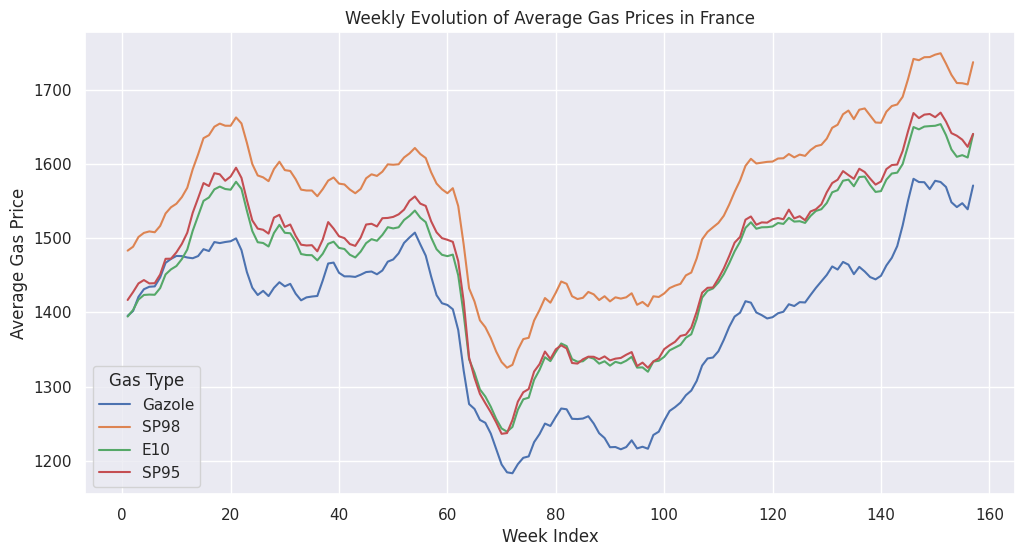

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average gas price for each gas type over the week index
average_prices = filtered_price_df.groupby("nom_carburant", "week_index").agg(F.avg("prix").alias("avg_price"))

# Convert the PySpark DataFrame to a Pandas DataFrame
average_prices_pd = average_prices.toPandas()

# Create a line plot using Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_prices_pd, x="week_index", y="avg_price", hue="nom_carburant")

# Set plot labels and title
plt.xlabel("Week Index")
plt.ylabel("Average Gas Price")
plt.title("Weekly Evolution of Average Gas Prices in France")

# Show the plot
plt.legend(title="Gas Type")
plt.show()

Represent a map for each gas type of France geo heat maps of price indexes, for example at department level using Folium to draw a map at department level.

In [ ]:
# Define the URL of the GeoJSON file
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson"

# Send an HTTP GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Save the content of the response to a file
    with open("departements.geojson", "wb") as file:
        file.write(response.content)
    print("GeoJSON file downloaded successfully.")
else:
    print("Failed to download the GeoJSON file.")

GeoJSON file downloaded successfully.


In [ ]:
from pyspark.sql.functions import avg, last

# Extract the department code from the postal code (first 2 digits of the postal code)
#To match the aggregation with the department codes in your GeoJSON file, you'll
#need to map postal codes to department codes.
#(Typically the first two digits of the postal code)
filtered_price_df= filtered_price_df.withColumn("department_code", col("cp").
                                                substr(1, 2))

# Use the last observed price_index for each department and gas type as the representative value
agg_data_df2 = filtered_price_df.groupBy("department_code", "nom_carburant").agg(
    last("price_index").alias("price_index")
)

In [ ]:
#Export Data from Spark to Python
agg_data_pandas = agg_data_df2.toPandas()

In [ ]:
import geopandas as gpd

# Load the GeoJSON file
geojson_path = '/content/departements.geojson'
france_departments = gpd.read_file(geojson_path)

# Loop through each gas type and create maps
for gas_type in agg_data_pandas['nom_carburant'].unique():
    map_data = agg_data_pandas[agg_data_pandas['nom_carburant'] == gas_type]

    # Print DataFrame structure and sample data
    print(f"Gas Type: {gas_type}")
    print(map_data.head())  # Display the first few rows

Gas Type: SP95
  department_code nom_carburant  price_index
0              37          SP95     6.838820
1              80          SP95     0.000000
3              51          SP95    -0.052165
5              57          SP95     0.000000
6              73          SP95     0.000000
Gas Type: Gazole
   department_code nom_carburant  price_index
2               38        Gazole    -3.914591
4               33        Gazole     0.000000
10              74        Gazole   -12.117306
12              39        Gazole    -0.121581
13              18        Gazole     1.579066
Gas Type: E10
   department_code nom_carburant  price_index
7               10           E10    10.599721
9               70           E10    -7.498767
11              12           E10     4.584041
15              89           E10    -5.915670
21              21           E10     5.211282
Gas Type: SP98
   department_code nom_carburant  price_index
18              25          SP98     1.986755
20              19       

In [ ]:
france_departments = gpd.read_file(geojson_path)
print(france_departments.head())  # Display the first few rows

  code                      nom  \
0   01                      Ain   
1   02                    Aisne   
2   03                   Allier   
3   04  Alpes-de-Haute-Provence   
4   05             Hautes-Alpes   

                                            geometry  
0  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2  POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...  
3  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  


In [ ]:
import folium
from branca.colormap import linear

# Loop through each gas type and create maps
for gas_type in agg_data_pandas['nom_carburant'].unique():

    # Filter the DataFrame for the current gas type
    map_data = agg_data_pandas[agg_data_pandas['nom_carburant'] == gas_type]

    # Create a map centered around France
    france_map = folium.Map(location=[46.2276, 2.2137], zoom_start=6)

    # Define the color scale
    min_value = map_data['price_index'].min()
    max_value = map_data['price_index'].max()
    colormap = linear.YlOrRd_09.scale(min_value, max_value).to_step(10)
    colormap.caption = f'Price Index for {gas_type}'
    colormap.add_to(france_map)

    def style_function(feature):
      department = feature['properties']['code']
      if department in map_data['department_code'].values:
        price_index = map_data.loc[map_data['department_code'] == department,
                                   'price_index'].values[0]
        color = colormap(price_index)
      else:
        # If no data is available for the department, set a default color
        color = 'gray'
      return {
        'fillOpacity': 0.7,
        'weight': 0.2,
        'fillColor': color
    }

    # Create the GeoJson object and add it to the map
    folium.GeoJson(
        france_departments,
        name='geojson',
        style_function=style_function,
    ).add_to(france_map)

    # Save the map to an HTML file
    filename = f'price_index_{gas_type}.html'
    france_map.save(filename)

# [VIII. Forecast next week price](#partVIII)<br>

The global idea of forecasting is in the following picture from the paper quoted in the assignment plan.

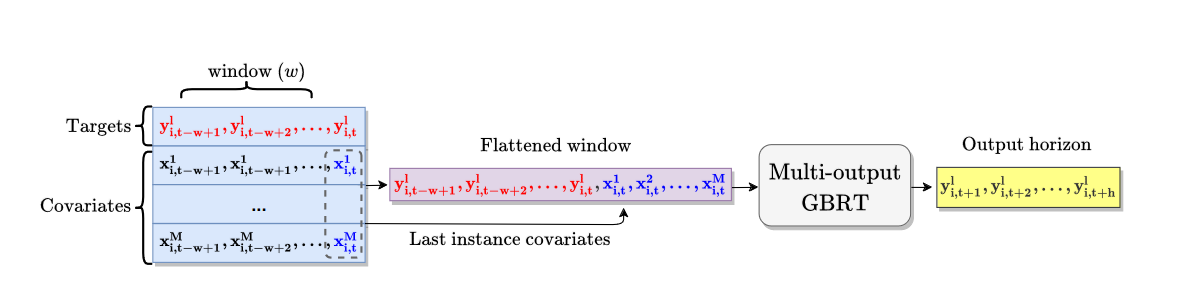


In our case, we shall not use a GBRT classifier but more common regression algorithms


## Data preparation

In order to have a ddf corresponding to the last image, we'll modify our ddf and specify (for the moment) one gas station and gas label specifically. Then, we'll aggregate the same ddf as before, but add prices on previous (up to 3 days before) days at the end of the row, and finally the target as last column.

As the column

In [ ]:
# Selecting appropriate covariates for calculation : salespoint, gas_label, price and week_index
ddf_for_ml = filtered_price_df.select("id_pdv" ,"id_carburant","prix","week_index")

In [ ]:
ddf_for_ml.printSchema()

root
 |-- id_pdv: integer (nullable = true)
 |-- id_carburant: integer (nullable = true)
 |-- prix: integer (nullable = true)
 |-- week_index: long (nullable = true)



In [ ]:
ddf_for_ml.withColumn("week_index",ddf_for_ml.week_index.cast('integer'))

DataFrame[id_pdv: int, id_carburant: int, prix: int, week_index: int]

In [ ]:
# Get distinct values of id_pdv
distinct_id_pdv = ddf_for_ml.select("id_pdv").distinct()
distinct_id_gas_label = ddf_for_ml.select("id_carburant").distinct()

In [ ]:
# Let's select a unique salespoint
salespoint = distinct_id_pdv.sample(withReplacement=False, fraction=0.1, seed=42).first()["id_pdv"]

In [ ]:
# Let's select a unique gas label
gas_label = distinct_id_gas_label.sample(withReplacement=False, fraction=0.3, seed=42).first()["id_carburant"]

In [ ]:
print(salespoint,gas_label)

14500008 2


In [ ]:
# Now let's limit our ddf to selected salespoint and gas label
ddf_prediction_filtered_salespoint = ddf_for_ml.filter("id_pdv == 1140001")
ddf_prediction_filtered_salespoint_and_gas_label = ddf_prediction_filtered_salespoint.filter("id_carburant == 1")

In [ ]:
# We shall keep only appropriate covariates
ddf_input = ddf_prediction_filtered_salespoint_and_gas_label.select("week_index","prix")
ddf_input.show(10)

+----------+----+
|week_index|prix|
+----------+----+
|         1|1370|
|         2|1399|
|         3|1429|
|         4|1439|
|         5|1429|
|         6|1439|
|         7|1459|
|         8|1479|
|         9|1479|
|        10|1469|
+----------+----+
only showing top 10 rows



In [ ]:
# Ordering the dataset to prep for Window
ddf_input.orderBy("week_index")

DataFrame[week_index: bigint, prix: int]

In [ ]:
# Now let's add the lag features as in the picture. We'll focus on 2 weeks previous forecast.
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Define a window specification to order data by "week_index"
windowSpec = Window.orderBy("week_index")

# Add a column "prev_price" that contains the price from 1 week ago using the lag function
ddf_input = ddf_input.withColumn("prev_price", lag("prix", 1).over(windowSpec))

# Add a column "prev_prev_price" that contains the price from 2 weeks ago using the lag function
ddf_input = ddf_input.withColumn("prev_prev_price", lag("prix", 2).over(windowSpec))

In [ ]:
ddf_input.show(10)

+----------+----+----------+---------------+
|week_index|prix|prev_price|prev_prev_price|
+----------+----+----------+---------------+
|         1|1370|      NULL|           NULL|
|         2|1399|      1370|           NULL|
|         3|1429|      1399|           1370|
|         4|1439|      1429|           1399|
|         5|1429|      1439|           1429|
|         6|1439|      1429|           1439|
|         7|1459|      1439|           1429|
|         8|1479|      1459|           1439|
|         9|1479|      1479|           1459|
|        10|1469|      1479|           1479|
+----------+----+----------+---------------+
only showing top 10 rows



In [ ]:
# Filtering out values with no previous forecast (first two rows)
ddf_input = ddf_input.filter("prev_price > 1" and "prev_prev_price > 1")
ddf_input.show(10)

In [ ]:
# Separating into train and test data at random
train_ddf, test_ddf = ddf_input.randomSplit([0.75, 0.25], seed=42)

In [ ]:
# Preparing the data for input into linear regression
from pyspark.ml.feature import StringIndexer, OneHotEncoder , Imputer,VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.regression import LinearRegression

# Define the input features for the linear regression model
op_features = VectorAssembler(inputCols=['week_index', 'prev_price', 'prev_prev_price'],
                              outputCol='features')  # Spark requires this format

# Create a pipeline stage for feature preparation
pipeline_features = Pipeline(stages=[op_features])

# Fit the feature preparation pipeline on the training data
pipeline_features.fit(train_ddf)

# Create a Linear Regression model instance
lr = LinearRegression(featuresCol="features", labelCol="prix")

# Create a pipeline that includes both feature preparation and the linear regression model
pipeline_lr = Pipeline(stages=[pipeline_features, lr])

# Fit the linear regression pipeline on the training data
fitted_lr = pipeline_lr.fit(train_ddf)

In [ ]:
# Calculation of predictions on test ddf
predictions_lr = fitted_lr.transform(test_ddf)

In [ ]:
# Conducting basic evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

# Define a function to evaluate a regression model and print various metrics
def evaluate_regression_model(predictions, label_col="prix", prediction_col="prediction"):

    # Create a RegressionEvaluator instance to compute regression metrics
    evaluator = RegressionEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="mse")

    # Calculate Mean Squared Error (MSE) using the evaluator
    mse = evaluator.evaluate(predictions)
    print(f"MSE: {mse}")
    print(f"RMSE: {mse**0.5}")

    # Change the metric to R-squared (coefficient of determination) and compute it
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    print(f"R-squared: {r2}")

# Call the evaluate_regression_model function with the predictions from the Linear Regression model
evaluate_regression_model(predictions_lr)

MSE: 1543.7059260887072
RMSE: 39.29002323858701
R-squared: 0.875265557444467


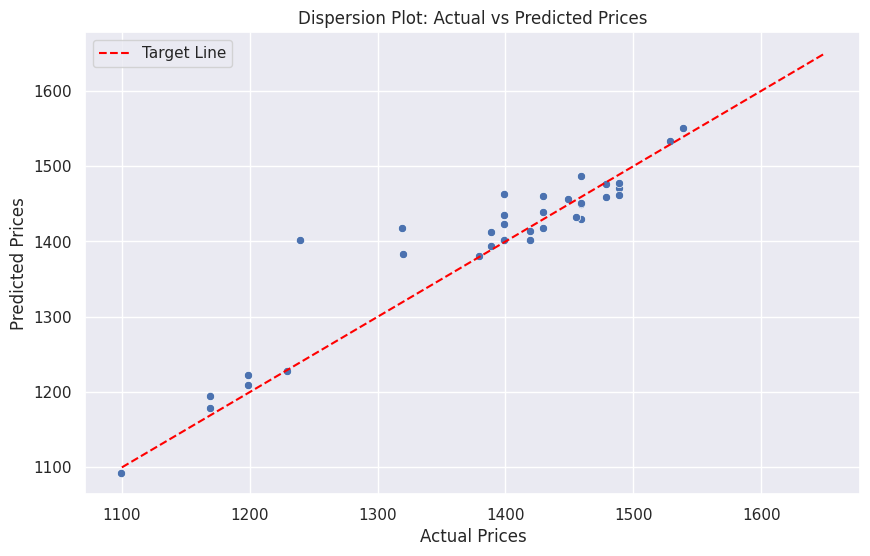

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the actual and predicted prices from the predictions dataframe
actual_prices = predictions_lr.toPandas()['prix'].tolist()
predicted_prices = predictions_lr.toPandas()['prediction'].tolist()

# Set the seaborn theme for plotting
sns.set_theme()

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Create a scatterplot to visualize the dispersion of actual vs. predicted prices
sns.scatterplot(x=actual_prices, y=predicted_prices)

# Add a red dashed line to represent the target line (where actual = predicted)
plt.plot([1100, 1650], [1100, 1650], linestyle='--', color='red', label='Target Line')

# Set the title of the plot
plt.title("Dispersion Plot: Actual vs Predicted Prices")

# Label the x-axis and y-axis
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# Let's move up one step and predict for all gas labels within a salespoint

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Select relevant columns from the dataframe and create a new dataframe
ddf_input_salespoint = ddf_prediction_filtered_salespoint.select("week_index", "prix", "id_carburant")

# Order the new dataframe by "week_index"
ddf_input_salespoint.orderBy("week_index")

# Define a window specification for partitioning by "id_carburant" and ordering by "week_index"
windowSpec = Window.partitionBy("id_carburant").orderBy("week_index")

# Apply the lag function to create a new column "prev_price" with prices from 1 week ago
ddf_input = ddf_input_salespoint.withColumn("prev_price", lag("prix", 1).over(windowSpec))

# Apply the lag function again to create a new column "prev_prev_price" with prices from 2 weeks ago
ddf_input = ddf_input.withColumn("prev_prev_price", lag("prix", 2).over(windowSpec))

In [ ]:
# Filter the DataFrame to include only rows where both "prev_price" and "prev_prev_price" are greater than 1
ddf_input = ddf_input.filter("prev_price > 1" and "prev_prev_price > 1")

# Split the filtered DataFrame into training and testing DataFrames
# Randomly split with a 75% train and 25% test ratio, using a fixed seed for reproducibility
train_ddf, test_ddf = ddf_input.randomSplit([0.75, 0.25], seed=42)

In [ ]:
# Define the feature assembler to create a 'features' column from specified input features
op_features = VectorAssembler(inputCols=['week_index', 'prev_price', 'prev_prev_price'],
                              outputCol='features')  # Spark requires this format

# Create a feature preparation pipeline stage that includes the feature assembler
pipeline_features = Pipeline(stages=[op_features])

# Fit the feature preparation pipeline on the training data
pipeline_features_model = pipeline_features.fit(train_ddf)

# Create a Linear Regression model instance with 'features' as input and 'prix' as the label
lr = LinearRegression(featuresCol="features", labelCol="prix")

# Create a pipeline that includes both feature preparation and the Linear Regression model
pipeline_lr = Pipeline(stages=[pipeline_features_model, lr])

# Fit the pipeline with the feature preparation and Linear Regression on the training data
fitted_lr = pipeline_lr.fit(train_ddf)

In [ ]:
# Calculation of predictions on test ddf
predictions_lr = fitted_lr.transform(test_ddf)

In [ ]:
# Call the evaluate_regression_model function with the predictions from the Linear Regression model
evaluate_regression_model(predictions_lr)

MSE: 4726.152112892021
RMSE: 68.7470153016989
R-squared: 0.6351797188108246


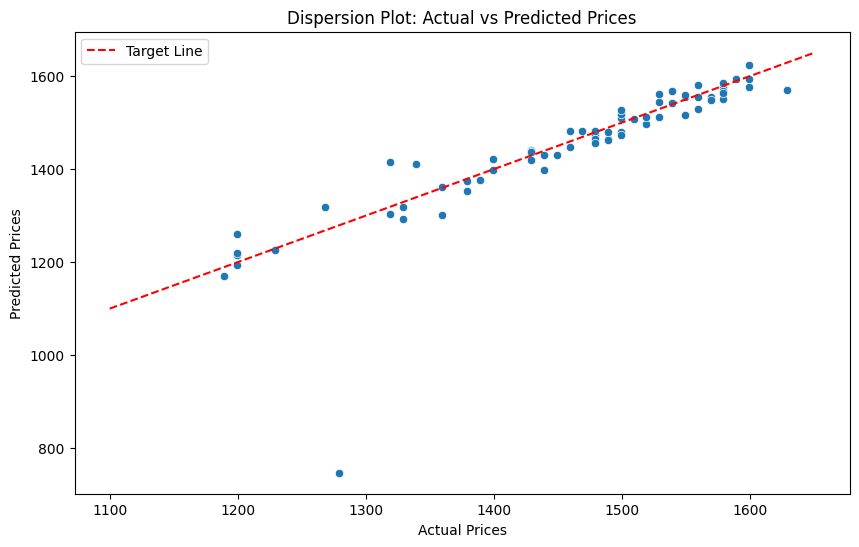

In [ ]:
# Extract the actual and predicted prices from the PySpark DataFrame and convert them to Python lists
actual_prices = predictions_lr.toPandas()['prix'].tolist()
predicted_prices = predictions_lr.toPandas()['prediction'].tolist()

# Set the seaborn theme for plotting
sns.set_theme()

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Create a scatterplot to visualize the dispersion of actual vs. predicted prices
sns.scatterplot(x=actual_prices, y=predicted_prices)

# Define the minimum and maximum values for the target line
min_value = 1100
max_value = 1650

# Add a red dashed line to represent the target line (where actual = predicted)
plt.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='red', label='Target Line')

# Set the title of the plot
plt.title("Dispersion Plot: Actual vs Predicted Prices")

# Label the x-axis and y-axis
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# What about prediction for a single gas label on all salespoints ?

In [ ]:
# Filter the DataFrame to select rows where "id_carburant" is equal to 1
ddf_prediction_gas_label = ddf_for_ml.filter("id_carburant == 1")

In [ ]:
# Import necessary libraries for working with PySpark
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Order the filtered DataFrame by "week_index"
ddf_prediction_gas_label.orderBy("week_index")

# Define a window specification for partitioning by "id_pdv" and ordering by "week_index"
windowSpec = Window.partitionBy("id_pdv").orderBy("week_index")

# Apply the lag function to create a new column "prev_price" with prices from 1 week ago
ddf_input = ddf_prediction_gas_label.withColumn("prev_price", lag("prix", 1).over(windowSpec))

# Apply the lag function again to create a new column "prev_prev_price" with prices from 2 weeks ago
ddf_input = ddf_input.withColumn("prev_prev_price", lag("prix", 2).over(windowSpec))

In [ ]:
# Filter the DataFrame to include only rows where both "prev_price" and "prev_prev_price" are greater than 1
ddf_input = ddf_input.filter("prev_price > 1" and "prev_prev_price > 1")

# Split the filtered DataFrame into training and testing DataFrames
# Randomly split with a 75% train and 25% test ratio, using a fixed seed for reproducibility
train_ddf, test_ddf = ddf_input.randomSplit([0.75, 0.25], seed=42)

In [ ]:
# Import necessary libraries for feature preparation and regression modeling using PySpark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressionModel, LinearRegression
from pyspark.ml.pipeline import Pipeline

# Define the feature assembler to create a 'features' column from specified input features
op_features = VectorAssembler(inputCols=['week_index', 'prev_price', 'prev_prev_price'],
                              outputCol='features')  # Required by Spark

# Create a feature preparation pipeline stage that includes the feature assembler
pipeline_features = Pipeline(stages=[op_features])

# Fit the feature preparation pipeline on the training data
pipeline_features_model = pipeline_features.fit(train_ddf)

# Create a Linear Regression model instance with 'features' as input and 'prix' as the label
lr = LinearRegression(featuresCol="features", labelCol="prix")

# Create a pipeline that includes both feature preparation and the Linear Regression model
pipeline_lr = Pipeline(stages=[pipeline_features_model, lr])

# Fit the pipeline with the feature preparation and Linear Regression on the training data
fitted_lr = pipeline_lr.fit(train_ddf)

In [ ]:
# Calculation of predictions on test ddf
predictions_lr = fitted_lr.transform(test_ddf)

In [ ]:
# Call the evaluate_regression_model function with the predictions from the Linear Regression model
evaluate_regression_model(predictions_lr)

MSE: 1005.3768537291802
RMSE: 31.707678151028027
R-squared: 0.9365367478232905


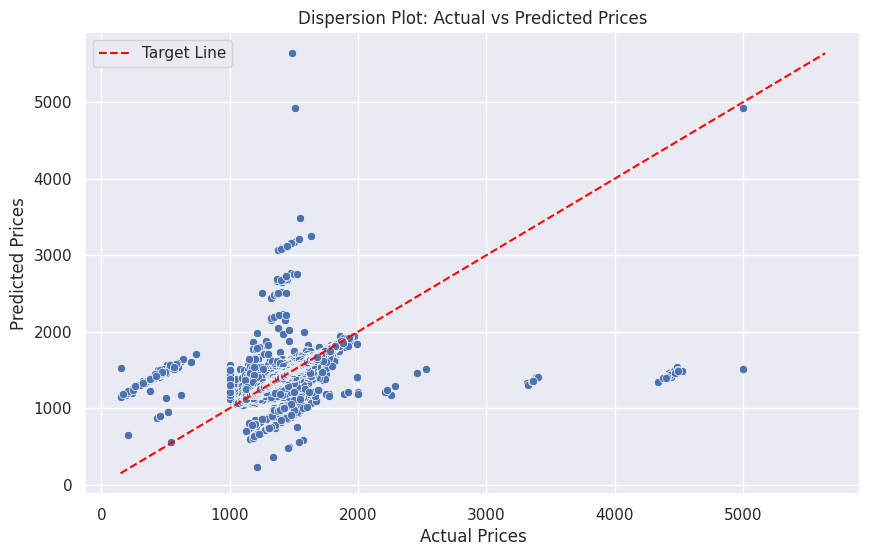

In [ ]:
# Extract the actual and predicted prices from the PySpark DataFrame and convert them to Python lists
actual_prices = predictions_lr.toPandas()['prix'].tolist()
predicted_prices = predictions_lr.toPandas()['prediction'].tolist()

# Set the seaborn theme for plotting
sns.set_theme()

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Create a scatterplot to visualize the dispersion of actual vs. predicted prices
sns.scatterplot(x=actual_prices, y=predicted_prices)

# Determine the minimum and maximum values for both actual and predicted prices
min_value = min(min(actual_prices), min(predicted_prices))
max_value = max(max(actual_prices), max(predicted_prices))

# Add a red dashed line to represent the target line (where actual = predicted)
plt.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='red', label='Target Line')

# Set the title of the plot
plt.title("Dispersion Plot: Actual vs Predicted Prices")

# Label the x-axis and y-axis
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# Now for all gas labels and station ids

Due to an out of memory error, this first test is done without encoding the gas labels and the salespoint id. This will be tested further down.


In [ ]:
# Order the DataFrame by "week_index" (note that this line may not be effective for ordering, see below)
ddf_for_ml.orderBy("week_index")

# Define a window specification for ordering by multiple columns: "week_index", "id_carburant", and "id_pdv"
windowSpec = Window.orderBy("week_index", "id_carburant", "id_pdv")

# Apply the lag function to create a new column "prev_price" with prices from 1 week ago
ddf_input = ddf_for_ml.withColumn("prev_price", lag("prix", 1).over(windowSpec))

# Apply the lag function again to create a new column "prev_prev_price" with prices from 2 weeks ago
ddf_input = ddf_input.withColumn("prev_prev_price", lag("prix", 2).over(windowSpec))

# Filter the DataFrame to include only rows where both "prev_price" and "prev_prev_price" are greater than 1
ddf_input = ddf_input.filter("prev_price > 1" and "prev_prev_price > 1")

# Split the filtered DataFrame into training and testing DataFrames
# Randomly split with a 75% train and 25% test ratio, using a fixed seed for reproducibility
train_ddf, test_ddf = ddf_input.randomSplit([0.75, 0.25], seed=42)

In [ ]:
# op_ohe_id_gas_label = OneHotEncoder(inputCol='id_carburant',outputCol='ohe_gas_label')
# op_ohe_id_salespoint = OneHotEncoder(inputCol='id_pdv',outputCol='ohe_salespoint')

# Define a VectorAssembler to create a 'features' column from specified input features
op_features = VectorAssembler(inputCols=['week_index', 'prev_price', 'prev_prev_price'],
                              outputCol='features')  # Required by Spark

# Create a feature preparation pipeline stage that includes the VectorAssembler
pipeline_features = Pipeline(stages=[op_features])

# Fit the feature preparation pipeline on the training data
pipeline_features_model = pipeline_features.fit(train_ddf)

# Create a Linear Regression model instance with 'features' as input and 'prix' as the label
lr = LinearRegression(featuresCol="features", labelCol="prix")

# Create a pipeline that includes both feature preparation and the Linear Regression model
pipeline_lr = Pipeline(stages=[pipeline_features_model, lr])

# Fit the pipeline with the feature preparation and Linear Regression on the training data
fitted_lr = pipeline_lr.fit(train_ddf)

In [ ]:
# Calculation of predictions on test ddf
predictions_lr = fitted_lr.transform(test_ddf)

In [ ]:
 # Call the evaluate_regression_model function with the predictions from the Linear Regression model
evaluate_regression_model(predictions_lr)

MSE: 2783.165281342326
RMSE: 52.75571325782949
R-squared: 0.8595672283586373


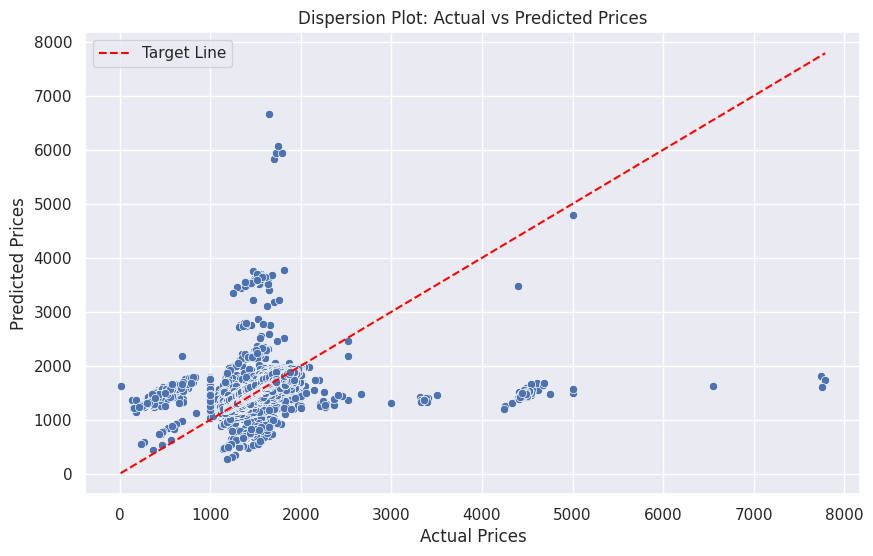

In [ ]:
# Extract the actual and predicted prices from the PySpark DataFrame and convert them to Python lists
actual_prices = predictions_lr.toPandas()['prix'].tolist()
predicted_prices = predictions_lr.toPandas()['prediction'].tolist()

# Set the seaborn theme for plotting
sns.set_theme()

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Create a scatterplot to visualize the dispersion of actual vs. predicted prices
sns.scatterplot(x=actual_prices, y=predicted_prices)

# Determine the minimum and maximum values for both actual and predicted prices
min_value = min(min(actual_prices), min(predicted_prices))
max_value = max(max(actual_prices), max(predicted_prices))

# Add a red dashed line to represent the target line (where actual = predicted)
plt.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='red', label='Target Line')

# Set the title of the plot
plt.title("Dispersion Plot: Actual vs Predicted Prices")

# Label the x-axis and y-axis
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# Full test with all encodings

To address out of memory error, sample size has been decreased.

In [ ]:
# Sample a fraction (0.001) of the DataFrame for machine learning purposes
# Using a specified seed (42) for reproducibility
ddf_for_ml_Sample = ddf_for_ml.sample(fraction=0.001, seed=42)

In [ ]:
ddf_for_ml_Sample.printSchema()

root
 |-- id_pdv: integer (nullable = true)
 |-- id_carburant: integer (nullable = true)
 |-- prix: integer (nullable = true)
 |-- week_index: long (nullable = true)



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Sample the data
ddf_for_ml_Sample = ddf_for_ml.sample(fraction=0.001, seed=42)

# Cast week_index to integer
ddf_for_ml_Sample = ddf_for_ml_Sample.withColumn("week_index", ddf_for_ml_Sample.week_index.cast('integer'))

# Order the sampled data
ddf_for_ml_Sample = ddf_for_ml_Sample.orderBy("week_index")

# Define the window specification
windowSpec = Window.partitionBy("id_carburant", "id_pdv").orderBy("week_index")

# Create lag features
ddf_input = ddf_for_ml_Sample.withColumn("prev_price", lag("prix", 1).over(windowSpec))
ddf_input = ddf_input.withColumn("prev_prev_price", lag("prix", 2).over(windowSpec))

# Filter out rows where lag features are null or less than or equal to 1
ddf_input = ddf_input.filter((ddf_input.prev_price > 1) & (ddf_input.prev_prev_price > 1))

# Split the data into training and testing sets
train_ddf, test_ddf = ddf_input.randomSplit([0.75, 0.25], seed=42)

**StringIndexer** and **OneHotEncoder** are used to handle categorical features (`id_pdv` and `id_carburant`), which, although represented as integers, are actually categories (gas stations and gas types).

- **StringIndexer** converts these categories into numerical indices, creating a unique numeric identifier for each category without implying any quantitative relationship between them.

- Then, **OneHotEncoder** transforms these indices into binary vectors, ensuring each category is represented as an equally distant point in the feature space.


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression

# StringIndexer
indexer_gas_label = StringIndexer(inputCol='id_carburant', outputCol='indexed_gas_label', handleInvalid='keep')
indexer_salespoint = StringIndexer(inputCol='id_pdv', outputCol='indexed_salespoint', handleInvalid='keep')

# OneHotEncoder
op_ohe_id_gas_label = OneHotEncoder(inputCol='indexed_gas_label', outputCol='ohe_gas_label')
op_ohe_id_salespoint = OneHotEncoder(inputCol='indexed_salespoint', outputCol='ohe_salespoint')

# VectorAssembler to combine feature columns
op_features = VectorAssembler(
    inputCols=['week_index', 'prev_price', 'prev_prev_price', 'ohe_gas_label', 'ohe_salespoint'],
    outputCol='features'
)

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="prix")

# Define the pipeline
pipeline_lr = Pipeline(stages=[
    indexer_gas_label, indexer_salespoint,
    op_ohe_id_gas_label, op_ohe_id_salespoint,
    op_features, lr
])

# Fit the pipeline on the training data
fitted_lr = pipeline_lr.fit(train_ddf)

In [ ]:
# Calculation of predictions on test ddf
predictions_lr = fitted_lr.transform(test_ddf)

In [ ]:
 # Call the evaluate_regression_model function with the predictions from the Linear Regression model
evaluate_regression_model(predictions_lr)

MSE: 12653.780994246295
RMSE: 112.48902610586642
R-squared: 0.4119894282931037


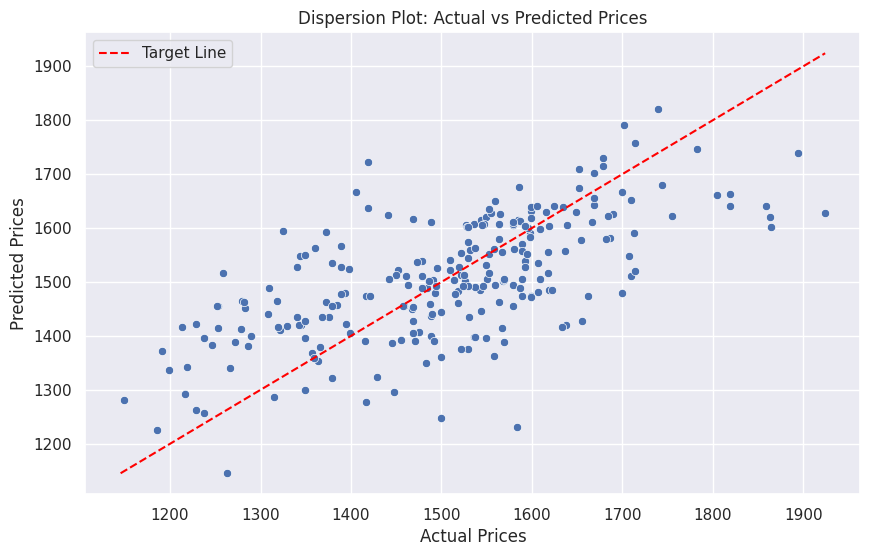

In [ ]:
# Extract the actual and predicted prices from the PySpark DataFrame and convert them to Python lists
actual_prices = predictions_lr.toPandas()['prix'].tolist()
predicted_prices = predictions_lr.toPandas()['prediction'].tolist()

# Set the Seaborn theme for plotting
sns.set_theme()

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Create a scatterplot to visualize the dispersion of actual vs. predicted prices
sns.scatterplot(x=actual_prices, y=predicted_prices)

# Determine the minimum and maximum values for both actual and predicted prices
min_value = min(min(actual_prices), min(predicted_prices))
max_value = max(max(actual_prices), max(predicted_prices))

# Add a red dashed line to represent the target line (where actual = predicted)
plt.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='red', label='Target Line')

# Set the title of the plot
plt.title("Dispersion Plot: Actual vs Predicted Prices")

# Label the x-axis and y-axis
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

## Full analysis of the performance of our predictors

| Test description | Sample Size | Mean squared error | Root mean squared error | R² |
| -------- | -------- | -------- | -------- | ------- |
| One salespoint, one gas label | 100 % |1543 | 39 |0.88 |
| One salespoint, all gas labels (not encoded) | 100 %| 4726 | 69 |0.64 |
| All salespoints (not encoded), one gas label | 100 %| 1005 | 32 |0.94 |
| All salespoints (not encoded), all gas labels (not encoded) | 100 %| 2783 | 53 |0.86 |
| All salespoints, all gas labels | 0.1 %| 12654 | 112 |0.41 |